# Notes

Fourth iteration of the modeling:
- modulirized data processing
- model serialization

In [1]:
import os 
import re
import csv
import json
import math
import random
import time

from itertools import chain
from datetime import datetime

import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

Start time

In [2]:
TIME = {}

TIME['start'] = time.time()

# Constants

In [3]:
SEQ_MAX_LEN = 600
NUM_CLASSES = 6
NUM_EXERCISES = 9
NUM_FLAG_BS = 2

In [4]:
dir_root = os.path.join('..')
dir_data_root = os.path.join(dir_root, 'data')
dir_exercises = os.path.join(dir_data_root, 'json', 'patients')
dir_exercises_augmented = os.path.join(dir_data_root, 'json', 'patients_augmented')
dir_exercises_test = os.path.join(dir_data_root, 'json', 'test')

**TODO** Implement augmenation and patients sessions for the new data set

# Data prep

### Build training set

In [5]:
TIME['data_processing_start'] = time.time()

In [6]:
from utils.input import setup, exercise_to_input

In [7]:
setup(os.path.join('..'), SEQ_MAX_LEN, NUM_EXERCISES, NUM_FLAG_BS)

{'ROOT_PATH': '..',
 'ALL_REGIONS': ['frontal', 'orbital', 'oral'],
 'REGIONS': {'LefteyeMidbottom': 'orbital',
  'LefteyeMidtop': 'orbital',
  'LefteyeInnercorner': 'orbital',
  'LefteyeOutercorner': 'orbital',
  'LefteyebrowInner': 'frontal',
  'LefteyebrowCenter': 'frontal',
  'RighteyeMidbottom': 'orbital',
  'RighteyeMidtop': 'orbital',
  'RighteyeInnercorner': 'orbital',
  'RighteyeOutercorner': 'orbital',
  'RighteyebrowInner': 'frontal',
  'RighteyebrowCenter': 'frontal',
  'NoseTip': 'frontal',
  'MouthLowerlipMidbottom': 'oral',
  'MouthLeftcorner': 'oral',
  'MouthRightcorner': 'oral',
  'MouthUpperlipMidtop': 'oral',
  'ChinCenter': 'oral',
  'ForeheadCenter': 'frontal',
  'LeftcheekCenter': 'oral',
  'RightcheekCenter': 'oral'},
 'BASES': {'LefteyeMidbottom': 'ForeheadCenter',
  'LefteyeMidtop': 'ForeheadCenter',
  'LefteyeInnercorner': 'ForeheadCenter',
  'LefteyeOutercorner': 'ForeheadCenter',
  'LefteyebrowInner': 'ForeheadCenter',
  'LefteyebrowCenter': 'ForeheadCenter

In [8]:
exercises_sources = [
    #dir_exercises_test
    dir_exercises,
    #dir_exercises_augmented
]

In [9]:
feature_engineering_setting = {
    'coordinates': True,
    'normalize_by_start': False,
    'normalize': False,
    'direction': True,
    'distance': True,
    'symetry_diference': False,
    're_base': True,
    'transformation_to_rebase': False,
    'extended_meta': True,
}

In [10]:
count = 0
for exercise_source in exercises_sources:
    for file_name in os.listdir(exercise_source):
        count += 1

test = int(count*0.2)
training_all = count - test
training = int(training_all*0.8)
validation = training_all - training
print(f'Overall number of examples: {count}')
print(f'Overall number of training examples: {training}')
print(f'Overall number of validation examples: {validation}')
print(f'Overall number of testing examples: {test}')

Overall number of examples: 2419
Overall number of training examples: 1548
Overall number of validation examples: 388
Overall number of testing examples: 483


In [11]:
xslist_meta = list()
xslist_global = list()
xslist_frontal = list()
xslist_oral = list()
xslist_orbital = list()
yslist = list()

for exercise_source in exercises_sources:
    for file_name in os.listdir(exercise_source):
        file_path = os.path.join(exercise_source, file_name)

        if file_name == '.DS_Store': continue
            
        _xs_meta, _xs_global, _xs_frontal, _xs_oral, _xs_orbital, _ys = exercise_to_input(file_path, feature_engineering_setting)

        yslist.append(_ys)
        xslist_meta.append(_xs_meta)  
        xslist_global.append(_xs_global)
        xslist_frontal.append(_xs_frontal)
        xslist_oral.append(_xs_oral)
        xslist_orbital.append(_xs_orbital)
            
ys = np.array(yslist, dtype='int')
xs_meta = np.array(xslist_meta, dtype='float32')   
xs_global = np.array(xslist_global, dtype='float32') 
xs_frontal = np.array(xslist_frontal, dtype='float32') 
xs_oral = np.array(xslist_oral, dtype='float32') 
xs_orbital = np.array(xslist_orbital, dtype='float32') 

print(ys.shape)
print(xs_meta.shape)
print(xs_global.shape)
print(xs_frontal.shape)
print(xs_oral.shape)
print(xs_orbital.shape)

(2419,)
(2419, 52)
(2419, 168, 600)
(2419, 48, 600)
(2419, 56, 600)
(2419, 64, 600)


Time preprocessing

In [12]:
TIME['data_processing_end'] = time.time()

## Modeling

In [13]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.utils import class_weight

In [14]:
def get_dnn(inputLayer, region='default'):     
    m = Dense(4, activation="relu",name=f'{region}-Dense-1')(inputLayer)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [15]:
def get_cnn(inputLayer, region='default'):
    chanDim = -1    
    m = Conv1D(16, 3, padding='same', activation='relu', name=f'{region}-Convolution-1')(inputLayer)
    m = BatchNormalization(axis=chanDim, name=f'{region}-Normalization-1')(m)
    m = MaxPooling1D((2), name=f'{region}-Pooling-1')(m)
    m = Conv1D(32, 3, padding='same', activation='relu', name=f'{region}-Convolution-2')(m)
    m = BatchNormalization(axis=chanDim, name=f'{region}-Normalization-2')(m)
    m = MaxPooling1D((2), name=f'{region}-Pooling-2')(m)
    m = Conv1D(64, 3, padding='same', activation='relu', name=f'{region}-Convolution-3')(m)
    m = BatchNormalization(axis=chanDim, name=f'{region}-Normalization-3')(m)
    m = MaxPooling1D((2), name=f'{region}-Pooling-3')(m)
    #m = Conv1D(64, 3, padding='same', activation='relu', name=f'{region}-Convolution-4')(m)
    #m = BatchNormalization(axis=chanDim, name=f'{region}-Normalization-4')(m)
    #m = MaxPooling1D((2), name=f'{region}-Pooling-4')(m)
    m = Flatten(name=f'{region}-Flatten-1')(m)
    m = Dropout(0.3, name=f'{region}-Dropout-1')(m)
    m = Dense(128, activation="relu", name=f'{region}-Dense-1')(m)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [16]:
def get_model():
    input_meta = Input(shape=xs_meta.shape[1:], name='Meta-Input')
    model_meta = get_dnn(input_meta, region='Meta')
    
    input_global = Input(shape=xs_global.shape[1:], name='Global-Input')
    model_global = get_cnn(input_global, region='Global')
    
    input_frontal = Input(shape=xs_frontal.shape[1:], name='Frontal-Input')
    model_frontal = get_cnn(input_frontal, region='Frontal')  

    input_oral = Input(shape=xs_oral.shape[1:], name='Oral-Input')
    model_oral = get_cnn(input_oral, region='Oral')  
    
    input_orbital = Input(shape=xs_orbital.shape[1:], name='Orbital-Input')
    model_orbital = get_cnn(input_orbital, region='Orbital')  
    
    
    model_contatenate = concatenate([
        model_meta.output, 
        model_global.output,
        model_frontal.output,
        model_oral.output,
        model_orbital.output,
    ])
    
    model_contatenate = Dense(32, activation="relu")(model_contatenate)
    model_contatenate = Dense(6, activation="softmax")(model_contatenate)
        
    model = Model(inputs=[
        model_meta.input,
        model_global.input,
        model_frontal.input,
        model_oral.input,
        model_orbital.input
    ], outputs=model_contatenate)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=Adam(learning_rate=1e-3, decay=1e-3 / 200),
        metrics=['accuracy']
    )
    
    
    return model

In [17]:
test_model = get_model()
test_model.summary()

Metal device set to: Apple M1


2024-12-16 15:53:57.521429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-16 15:53:57.523471: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Global-Input (InputLayer)      [(None, 168, 600)]   0           []                               
                                                                                                  
 Frontal-Input (InputLayer)     [(None, 48, 600)]    0           []                               
                                                                                                  
 Oral-Input (InputLayer)        [(None, 56, 600)]    0           []                               
                                                                                                  
 Orbital-Input (InputLayer)     [(None, 64, 600)]    0           []                               
                                                                                            

In [18]:
print(set(ys))

{0, 1, 2, 3, 4, 5}


### K-fold evaluation

In [19]:
k = 5
k_limit = 1
train = 0.8
val = 0.2
test = 0.2

In [20]:
VERBOSE = 0
EPOCHS = 400
BATCH_SIZE = 16

In [21]:
from sklearn.model_selection import KFold

In [22]:
def get_k_indx(k, n):

    k_fold = KFold(n_splits=k)
    train_ = []
    val_ = []
    test_ = []
    indx = []

    for train_indices, test_indices in k_fold.split(ys):
        n_k = len(train_indices)
        val_split = int(n_k * train)
        indx.append([train_indices[:val_split],train_indices[val_split + 1:], test_indices])
    
    return indx

In [23]:
%matplotlib inline

2024-12-16 17:54:47.008288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 17:54:55.254305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:17:14.684097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.85      0.88      0.86       234
           1       0.76      0.70      0.73        67
           2       0.73      0.67      0.70        61
           3       0.80      0.92      0.86        26
           4       0.76      0.93      0.84        28
           5       0.87      0.78      0.82        68

    accuracy                           0.82       484
   macro avg       0.80      0.81      0.80       484
weighted avg       0.82      0.82      0.82       484



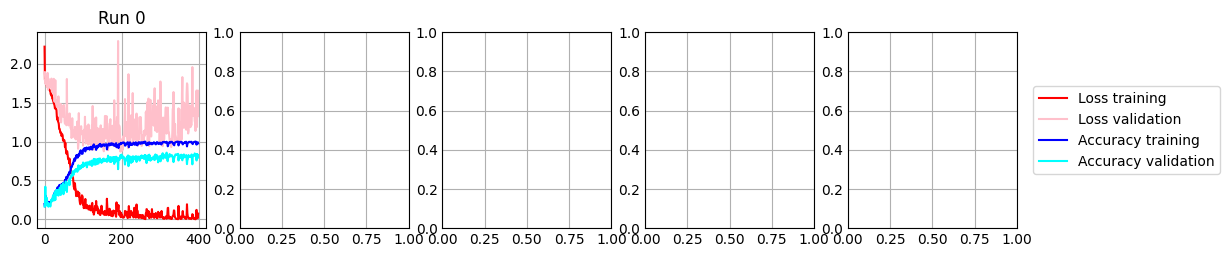

<Figure size 200x200 with 0 Axes>

In [29]:
indxs = get_k_indx(k, len(ys))
models = []

fig, axs = plt.subplots(1,5,figsize=(10,2)) 
colors = ['red', 'pink', 'blue', 'cyan']
labels = ['Loss training', 'Loss validation', 'Accuracy training', 'Accuracy validation']

for i in range(k_limit):
    TIME[f'k_{i}_training_start'] = time.time()
    train_indx, val_indx, test_indx  = indxs[i]

    xs_meta_i = xs_meta[train_indx]
    xs_meta_i_val = xs_meta[val_indx]
    xs_meta_i_test = xs_meta[test_indx]
    
    xs_global_i = xs_global[train_indx]
    xs_global_i_val = xs_global[val_indx]
    xs_global_i_test = xs_global[test_indx]
    
    xs_frontal_i = xs_frontal[train_indx]
    xs_frontal_i_val = xs_frontal[val_indx]
    xs_frontal_i_test = xs_frontal[test_indx]
    
    xs_oral_i = xs_oral[train_indx]
    xs_oral_i_val = xs_oral[val_indx]
    xs_oral_i_test = xs_oral[test_indx]
    
    xs_orbital_i = xs_orbital[train_indx]
    xs_orbital_i_val = xs_orbital[val_indx]
    xs_orbital_i_test = xs_orbital[test_indx]
    
    ys_i = ys[train_indx]
    ys_i_val = ys[val_indx]
    ys_i_test = ys[test_indx]
    
    
    class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes = np.unique(ys_i),
                                                 y=ys_i)
    available_classes = np.unique(ys_i)
    weight_training_classes = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
    }
    
    for indx, value in enumerate(class_weights):
        weight_training_classes[available_classes[indx]] = value

    #print(weight_training_classes)

    model = get_model()

    model_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=20)
    ]

    hist = model.fit(
        x=[
            xs_meta_i, 
            xs_global_i, 
            xs_frontal_i,
            xs_oral_i,
            xs_orbital_i], y=ys_i, 
        validation_data=([
            xs_meta_i_val,
            xs_global_i_val,
            xs_frontal_i_val,
            xs_oral_i_val,
            xs_orbital_i_val], ys_i_val),
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS,
        class_weight=weight_training_classes,
        #callbacks=model_callbacks,
        verbose=VERBOSE)
    
    models.append(model)

    # visualizing losses and accuracy
    train_loss = hist.history['loss']
    val_loss   = hist.history['val_loss']
    train_acc  = hist.history['accuracy']
    val_acc    = hist.history['val_accuracy']
    xc         = range(len(hist.history['loss']))    
    
    axs[i].set_title(f'Run {i}')
    axs[i].plot(xc, train_loss, color=colors[0], label=labels[0])
    axs[i].plot(xc, val_loss, color=colors[1], label=labels[1])
    axs[i].plot(xc, train_acc, color=colors[2], label=labels[2])
    axs[i].plot(xc, val_acc, color=colors[3], label=labels[3])
    
    TIME[f'k_{i}_training_end'] = time.time()
    TIME[f'k_{i}_evaluation_start'] = time.time()

    y_pred = model.predict([
        xs_meta_i_test,
        xs_global_i_test,
        xs_frontal_i_test,
        xs_oral_i_test,
        xs_orbital_i_test],verbose=0)
    y_pred_bool = np.argmax(y_pred, axis=1)
    
    TIME[f'k_{i}_evaluation_end'] = time.time()

    print(classification_report(ys_i_test, y_pred_bool))
    
fig.legend(labels, ncol=1, bbox_to_anchor=(1.2,0.5), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

plt.show()
plt.savefig(f'mphnn_runs_02_{int(time.time())}.svg', format='svg', dpi=1200)    

End time

In [25]:
TIME['end'] = time.time()

In [26]:
print(f'Total processing took {TIME["end"] - TIME["start"]}')
print(f'Data processing took {TIME["data_processing_end"] - TIME["data_processing_start"]}')
for i in range(k_limit):
    print(f'Run {i} took training {TIME[f"k_{i}_training_end"] - TIME[f"k_{i}_training_start"]} evaluation {TIME[f"k_{i}_evaluation_end"] - TIME[f"k_{i}_evaluation_start"]}')


Total processing took 2038.9394471645355
Data processing took 453.13435196876526
Run 0 took training 1581.930465221405 evaluation 2.418992042541504


In [27]:
Total processing took 11175.106185913086
Data processing took 2145.1009118556976
Run 0 took training 9018.474169969559 evaluation 9.362757205963135

SyntaxError: invalid syntax (2521010338.py, line 1)

In [ ]:
a = [2.924945831298828, 3.651282787322998, 4.806945085525513, 5.401340961456299, 6.65657901763916]
(sum(a)/len(a))/484

In [ ]:
a = [1600.00035572052, 1513.8305730819702, 1569.2452821731567, 1600.6460349559784, 1670.5405218601227]
(sum(a)/len(a))

In [ ]:
9.362757205963135 / 2419

# Model Serialization 

In [ ]:
serialize = False
best_model = 2

In [ ]:
dir_models = os.path.join(dir_root, 'models')
dir_model = os.path.join(dir_models, 'type4-with-fe_aug_006')

In [ ]:
if serialize:
    model = models[best_model]
    model.save(dir_model)